# What happened to pop music lyrics in the last 50 years?¶

This notebook analyzes the lyrics of pop songs contained in the Billboard Year-End Hot 100 between 1965 and 2015, which measures their performances throughout the year in the U.S. 
Data Source: https://github.com/walkerkq/musiclyrics

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [2]:
df2 = pd.read_csv("billboard_lyrics_1964-2015.csv",delimiter=',', encoding='latin-1')

## 1. Basic summary of dataset

The dataset contains 5100 songs and 6 features.

In [3]:
print("These are the features: ", list(df2.columns))

These are the features:  ['Rank', 'Song', 'Artist', 'Year', 'Lyrics', 'Source']


In [4]:
df2.shape

(5100, 6)

For the analysis, we drop all song rows with missing information. 

In [5]:
# drop rows with missing values
df2.dropna(axis=0, how='any',inplace=True)
df2 = df2[df2.Lyrics != " NA "]
df2.dropna( how='any', subset=['Lyrics'], inplace=True)
#reset index
df2.reset_index(inplace=True, drop=True)

In [6]:
print("The number of remaining songs is: ", df2.shape[0])

The number of remaining songs is:  4897


## 2. Analysis of Billboard top 100 songs 

In [7]:
#PREPROCESSING
# apply word tokenizer, delete stopwords, and apply lemmatizer
tokens=[]
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

for row in df2.Lyrics:
    row_tokens=word_tokenize(row)
    filtered_sent = [w for w in row_tokens if not w.lower() in stop_words]
    stemmed = [lemmatizer.lemmatize(word) for word in filtered_sent]
    tokens.append(stemmed)

In [8]:
#add tokens to dataframe
df2['Tokens']=tokens

First, lets see how the number of unique words per song has evolved over time...

In [9]:
#get no of unique words per song lyric
count_words=[]
for row in df2.Tokens:
    unique = set(row) 
    count_words.append(len(unique))
#and add to df
df2["unique_words"]=count_words

In [10]:
#keep only rows where no of words !=0
df2=df2[df2['unique_words']!=0]
#and remove songs that are instrumental
df2=df2[df2['Lyrics']!='instrumental']
df2=df2[df2['Lyrics']!=' instrumental']
df2=df2[df2['Lyrics']!=' instrumental ']
df2=df2[df2['Lyrics']!='instrumental ']

In [11]:
words_by_y=df2.groupby('Year').mean()[['unique_words']]

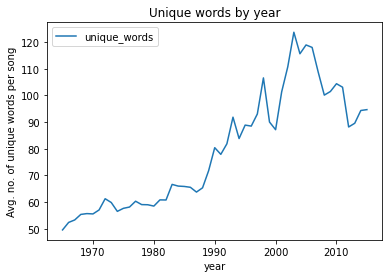

In [12]:
ax = sns.lineplot(data=words_by_y).set(title='Unique words by year', xlabel='year', ylabel='Avg. no. of unique words per song')

In [13]:
print("Year of peak sophistication in lyrics: ", words_by_y.index.max(), "No of words: ", round(words_by_y.max()[0]))

Year of peak sophistication in lyrics:  2015 No of words:  124


In 2015, the top 100 songs contained, on average, 124 words, while they only contained less than 50 in 1965. Since 2015, words per song are on a downwards trend. 

### And what are the songs with the most and least no. of words?

Most words

In [14]:
df2[['Artist', 'Song', 'Year','Lyrics', 'unique_words']].loc[ df2["unique_words"]==df2["unique_words"].max()]


,Artist,Song,Year,Lyrics,unique_words
3157,puff daddy featuring the notorious big and mase,been around the world,1998,intro mase yo yo this mase youknowhatimsayin ...,347


Least words - excluding instrumental songs

In [15]:
df2[['Artist', 'Song', 'Year','Lyrics', 'unique_words']].loc[ df2["unique_words"]==df2["unique_words"].min()]

,Artist,Song,Year,Lyrics,unique_words
155,the surfaris,wipe out,1966,wipe out ha ha ha,2


### The number of words has increased considerably. But what are the top 20 words in all 50 years of Billboard music?

...we start with a simple word cloud

In [ ]:
#make one list of words for all lyrics for word cloud
words =''
for lyric in tokens:
    for word in lyric:
        words= words +" " + str(word)


fig, ax = plt.subplots(figsize=(15, 5))


plt.subplot(1,2,1)
wordcloud = WordCloud(width=1800,height=1400).generate(words)
plt.imshow(wordcloud)
plt.title('Word cloud of 50 years of billboard top 100 lyrics')
plt.axis("off")


plt.show()

In [ ]:
#count words
word_counter={}
for lyric in tokens:
    for word in lyric:
        if word != '':
            if word in word_counter:
                word_counter[word] +=1
            else:
                word_counter[word] = 1

In [ ]:
df_freq=pd.DataFrame.from_dict(word_counter, orient="index", columns=['frequencies'])
df_freq['words'] = df_freq.index
df_freq.sort_values(by="frequencies", ascending=False, inplace=True)
df_freq.reset_index(inplace=True, drop=True)

In [ ]:
sns.set_theme(style="whitegrid")
sns.barplot(x='words', y='frequencies', data=df_freq[0:20]).set_title("Top 20 words")
plt.xticks(rotation=70)
plt.figure(figsize=(20,15))
plt.tight_layout()


Surprise! Love is the no. 1 word in all 50 years of pop music, occuring more than 12000 times in all lyrics. 

### Love, yeah, baby: over time

Among the top 20 we find words such as love, yeah, and baby. But how has their popularity evolved over time?

In [ ]:
#by year

word_counter_year={}

for y in df2.Year:
    word_counter={}
    df=df2.loc[df2.Year==y]
    for lyric in df.Tokens:
        for word in lyric:

            if word != '':
                if word in word_counter:
                    word_counter[word] +=1
                else:
                    word_counter[word] = 1
    word_counter_year[y] = word_counter 
df_freq_y=pd.DataFrame.from_dict(word_counter_year, orient="columns")
df_freq_y=df_freq_y.rename_axis('words').reset_index()

In [ ]:
df_freq_y=df_freq_y.set_index(df_freq_y.columns[0])

In [ ]:
#replace frequencies by percentages
df_perc_y= (df_freq_y / df_freq_y.sum(axis=0,skipna=True)) * 100

In [ ]:
#make plot of frequency of the word love and yeah by year

frequency_love=df_perc_y.loc[df_perc_y.index=='love'].T
frequency_yeah=df_perc_y.loc[df_perc_y.index=='yeah'].T
frequency_baby=df_perc_y.loc[df_perc_y.index=='baby'].T
frequency_y = pd.concat([frequency_love,frequency_yeah, frequency_baby], axis=1)


In [ ]:
ax = sns.lineplot(data=frequency_y).set(title='Love, yeah, baby over time', xlabel='year', ylabel='% of occurence')


The word "love" peaked in 1979, where it made up 4 percent of all words in all songs! From there on, "love" seems to deteriorate. "Baby" also seems to be on a downward trend, while "yeah" is pretty steady.

### Top 10 words by decade

Are the top 10 words pretty stable, or have they varied a lot over time?

In [ ]:
decade=list(df2.Year//10*10+5)
decade = [2005 if dec==2015 else dec for dec in decade]
df2['Decade']=decade
decade=list(set(decade))

In [ ]:
#count words by decade
word_counter_dec={}

for decade in df2.Decade:
    word_counter={}
    df=df2.loc[df2.Decade==decade]
    for lyric in df.Tokens:
        for word in lyric:

            if word != '':
                if word in word_counter:
                    word_counter[word] +=1
                else:
                    word_counter[word] = 1
    word_counter_dec[decade] = word_counter       


In [ ]:
df_freq_dec=pd.DataFrame.from_dict(word_counter_dec, orient="columns")

In [ ]:
#replace frequencies by percentages
df_perc_dec= (df_freq_dec / df_freq_dec.sum(axis=0,skipna=True)) * 100

In [ ]:
df_perc_dec.sort_values(by=1985, ascending=False)

In [ ]:
decade.sort()

In [ ]:
top10_decades={}

for dec in decade:
    top10=list(df_perc_dec.sort_values(by=dec, ascending=False)[0:10].loc[:,dec].reset_index().iloc[:, 0])
    top10_decades[dec]=top10
     

These are the top10 words per decade...

In [ ]:
for items in top10_decades.items():
    print(items)

In [ ]:
list_all=[]
for key, value in top10_decades.items():
    list_all=list_all + value
list_all=set(list_all)

Turns out the top 10 words of 5 decades consist only in 15 words. So there is little variation over time. Here they are:

In [ ]:
print(list_all)

In [ ]:
df_perc_dec=df_perc_dec.rename_axis('words').reset_index()

In [ ]:
#get percentages for words that were top 10 in 1965-1975

freq_top={}
for word in top10_decades[1965]:
    freq=df_perc_dec.loc[df_perc_dec['words']==word]
    freq=freq.iloc[0,1:6]
    freq_top[word]=list(freq)
freq_top=pd.DataFrame.from_dict(freq_top, orient="index")
freq_top.columns=['1965-1974', '1975-1984', '1985-1995', '1995-2004', '2005-2015']
freq_top.sort_values(by='1965-1974', ascending=False, inplace=True)
freq_top.index.name = 'words'


In [ ]:
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.2)
plt.figure(figsize=(10,6))
freq_top.T.plot.bar(stacked=True, ax=plt.gca())
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1],labels[::-1], loc=1,   bbox_to_anchor=(1.2,0.9))
plt.ylabel("% in all billboard 100 songs")
sns.despine()